## Q1. Load the Dataset and Preprocessing

In [1]:
import pandas as pd
import spacy
from typing import List

# Load and preprocess the data
df = pd.read_csv('spam.csv', encoding='latin-1')
df = df.drop(columns=['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'])
df.columns = ['label', 'message']

# Calculating percentages
total_rows = len(df)
ham_count = df[df['label'] == 'ham'].shape[0]
spam_count = df[df['label'] == 'spam'].shape[0]
ham_percentage = (ham_count / total_rows) * 100
spam_percentage = (spam_count / total_rows) * 100
print(f"ham: {ham_percentage:.2f}%")
print(f"spam: {spam_percentage:.2f}%")

# Function to clean text using spaCy
nlp = spacy.load('en_core_web_sm')
def spacy_clean_text(text: str) -> List[str]:
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if not token.is_stop and token.is_alpha]
    return ' '.join(tokens)

df['tokens_message'] = df['message'].apply(spacy_clean_text)
df = df.drop(columns=['message'])
df.columns = ['Label', 'Message']


/Users/anxiousviking/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


ham: 86.59%
spam: 13.41%


## Q2. Provide the metric for evaluation model

Choosing F1 score for Spam Detection

Imbalanced Data Handling:
Dataset is imbalanced (86.6% ham, 13.4% spam). Accuracy alone can be misleading as a model predicting only ham would still have high accuracy. The F1 score balances precision and recall, providing a more meaningful assessment.

Balancing Precision and Recall:
Precision: Ensures that predicted spam emails are actually spam, reducing false positives.
Recall: Measures how many actual spam emails are correctly identified, minimizing false negatives.
The F1 score combines these into a single metric, reflecting both aspects.

Reflects True Performance:
In an imbalanced dataset, the F1 score highlights the model's effectiveness in distinguishing spam from ham, ensuring it identifies spam while avoiding incorrect labeling of legitimate emails.

Overall, the F1 score provides a balanced measure of performance, crucial for effective spam detection in imbalanced datasets.

## Q3: Classification Pipelines

Objective: Evaluate and compare three different classification pipelines for spam detection using a subset of the dataset. Choose the best pipeline based on model performance and learning curves, then train the final model on a larger subset.

### Intial testing with smaller subset:

#### Pipeline 1: Sparce Embeddings

F1 Score for TF-IDF only with class weights: 0.9183673469387754


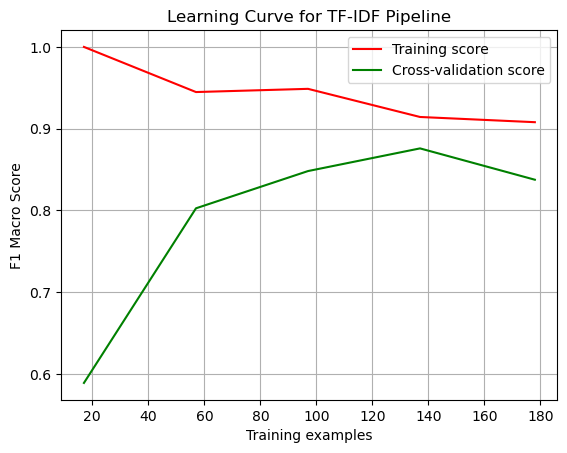

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.model_selection import learning_curve
import numpy as np
import matplotlib.pyplot as plt

# Subset of dataset
sample_df = df.sample(frac=0.05, random_state=40)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(sample_df['Message'], sample_df['Label'], test_size=0.2, random_state=40)

# TF-IDF Vectorizer
tfidf = TfidfVectorizer(min_df=5, max_df=0.9, ngram_range=(1,2), max_features=1000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Train and evaluate the TF-IDF model
model1 = LogisticRegression(max_iter=1000, class_weight='balanced')
model1.fit(X_train_tfidf, y_train)
y_pred_tfidf = model1.predict(X_test_tfidf)
f1_tfidf = f1_score(y_test, y_pred_tfidf, average='macro')
print(f"F1 Score for TF-IDF only with class weights: {f1_tfidf}")

# Plot learning curve for TF-IDF pipeline
def plot_learning_curve(estimator, X, y, title):
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=5, scoring='f1_macro', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 5))
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    plt.figure()
    plt.title(title)
    plt.plot(train_sizes, train_scores_mean, label="Training score", color="r")
    plt.plot(train_sizes, test_scores_mean, label="Cross-validation score", color="g")
    plt.xlabel("Training examples")
    plt.ylabel("F1 Macro Score")
    plt.legend(loc="best")
    plt.grid()
    plt.show()

plot_learning_curve(model1, X_train_tfidf, y_train, "Learning Curve for TF-IDF Pipeline")


#### Pipeline 2: Feature Engineering

F1 Score for Feature Engineering only with class weights: 0.7171717171717171


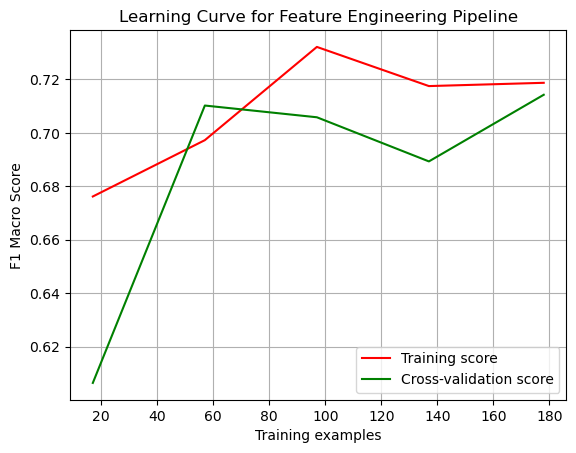

In [7]:
from spellchecker import SpellChecker

spell = SpellChecker()

def feature_engineering(text):
    return {
        'char_count': len(text),
        'word_count': len(text.split()),
        'digit_count': sum(char.isdigit() for char in text),
        'spelling_mistakes': len(spell.unknown(text.split()))
    }

# Apply feature engineering to sample_df
engineered_features = sample_df['Message'].apply(lambda x: pd.Series(feature_engineering(x)))

# Train-test split on engineered features
X_train_feat, X_test_feat, y_train_feat, y_test_feat = train_test_split(engineered_features, sample_df['Label'], test_size=0.2, random_state=40)

# Train and evaluate the Feature Engineering model
model2 = LogisticRegression(max_iter=1000, class_weight='balanced')
model2.fit(X_train_feat, y_train_feat)
y_pred_feat = model2.predict(X_test_feat)
f1_feat = f1_score(y_test_feat, y_pred_feat, average='macro')
print(f"F1 Score for Feature Engineering only with class weights: {f1_feat}")

# Plot learning curve for Feature Engineering pipeline
plot_learning_curve(model2, X_train_feat, y_train_feat, "Learning Curve for Feature Engineering Pipeline")


#### Pipeline 3: Sparse Embeddings (TF-IDF) + Feature Engineering

F1 Score for TF-IDF + Feature Engineering with class weights: 0.7781550650820599


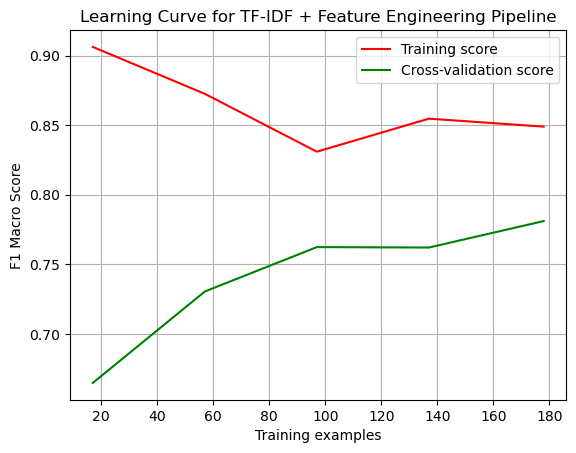

In [8]:
from scipy.sparse import hstack

# Concatenate TF-IDF matrix with engineered features
X_train_combined = hstack([X_train_tfidf, X_train_feat])
X_test_combined = hstack([X_test_tfidf, X_test_feat])

# Train and evaluate the combined TF-IDF + Feature Engineering model
model3 = LogisticRegression(max_iter=1000, class_weight='balanced')
model3.fit(X_train_combined, y_train)
y_pred_combined = model3.predict(X_test_combined)
f1_combined = f1_score(y_test, y_pred_combined, average='macro')
print(f"F1 Score for TF-IDF + Feature Engineering with class weights: {f1_combined}")

# Plot learning curve for TF-IDF + Feature Engineering pipeline
plot_learning_curve(model3, X_train_combined, y_train, "Learning Curve for TF-IDF + Feature Engineering Pipeline")


Pipeline 1 (TF-IDF only): F1 Score = 0.918
Pipeline 2 (Feature Engineering only): F1 Score = 0.7171
Pipeline 3 (TF-IDF + Feature Engineering): F1 Score = 0.778

Analysis:

Pipeline 1 (TF-IDF only):
This pipeline performs reasonably well with an F1 score of 0.918. TF-IDF captures the term importance and frequency, which is useful for distinguishing spam from ham messages.

Pipeline 2 (Feature Engineering only):
This pipeline performs poorly with an F1 score of 0.7171. This suggests that the engineered features alone are not effective for spam detection. Feature engineering in this case may not capture the complexities of spam vs. ham classification.

Pipeline 3 (TF-IDF + Feature Engineering):
This pipeline performs the best with an F1 score of 0.778. Combining TF-IDF with engineered features helps capture both term importance and additional characteristics of the messages, improving classification performance.

Conclusion:

Pipeline 1 is the best choice based on the highest F1 score. It avoids any case over fitting that might occur due to over complex code as in pipeline-3